In [ ]:
# Rafael Rocha Mattazio
# nºUSP 6516211
# SCC5830 (2022/1)
# Assignment 6 = Color Image Processing and Segmentation

In [1]:
import numba as nb

In [2]:
from numba import jit, prange

In [3]:
import random
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [4]:
# from platform import python_version ; print(python_version() == '3.9.2')
# print(np.__version__ == '1.22.3')
# print(imageio.__version__ == '2.16.1')
# import matplotlib ; print(matplotlib.__version__ == '3.5.1')

In [5]:
# Read input
path_img = "img-db/"

img_ipt = 'IMG_8780.JPG'
attr_option = 3
clusters = 4
total_iter = 10
seed = 1618

In [6]:
# Check range of parameters
# assert (query >= 0) and (query < dataset_size) , "Index of image for query must be [0, dataset_size]"
# for num in neighbour:
#     assert num in [-1, 0, 1], "Neighbour pixel must be anyone near, that is x,y in [-1,1]"  # (num >= -1) and (num <=1)
# assert morph_mod_type in [1, 2], "Morphology modification methods allowed are 1-Opening or 2-Closing"
# assert (thresh_binary >= 0) and (thresh_binary <= 255) , "The threshold for image binarization must be in [0,255]"
# assert dataset_size > 0, "There must be at least one image in the dataset"
# assert len(img_names) > 0, "There wasn't any name of image for the dataset or they wasn't recognized"

In [7]:
# Read input image
img_src = path_img + img_ipt
img_in = (imageio.imread(img_src)).astype(np.float32)  #[:5,:5,:]
m = img_in.shape[0]
n = img_in.shape[1]

In [8]:
def luminance(img_in, r=0.299, g=0.587, b=0.114):
    # Default parameter values are for luminance conversion
    img_float = np.array(img_in).astype(np.float32)
    img_lum = (r*img_float[:,:,0] + g*img_float[:,:,1] + b*img_float[:,:,2])
    
    return img_lum

In [9]:
# Reshape image according to attribute option
# x = np.array([m*[i] for i in range(m)]).astype(np.float32)
# x1d = x.reshape((1,x.shape[0]*x.shape[1]))
# y = np.array([[j for j in range(n)] for i in range(m)]).astype(np.float32)
# y1d = y.reshape((1,y.shape[0]*y.shape[1]))

# if ((attr_option == 1) | (attr_option == 2)):
#     img_1dr = img_in[:,:,0].reshape((1,m*n))
#     img_1dg = img_in[:,:,1].reshape((1,m*n))
#     img_1db = img_in[:,:,2].reshape((1,m*n))
# elif ((attr_option == 3) | (attr_option == 4)):
#     img_lum = luminance(img_in)
#     img_1d = img_lum.reshape((1,img_lum.shape[0]*img_lum.shape[1]))
# else:
#     raise ValueError("Option value not found")

In [10]:
# attr_option = 4
# clusters = 3

In [11]:
# Stack attributes
x = np.array([m*[i] for i in range(m)]).astype(np.float32)
y = np.array([[j for j in range(n)] for i in range(m)]).astype(np.float32)

luminance_out = False
if attr_option == 1:
    img_attr = img_in
elif attr_option == 2:
    img_attr = np.stack([img_in[:,:,0], img_in[:,:,1], img_in[:,:,2], x, y], axis=2)
elif attr_option == 3:
    luminance_out = True
    img_attr = np.stack([luminance(img_in)], axis=2)  # Nothing is stacked, but allows compatibility with further methods
elif attr_option == 4:
    luminance_out = True
    img_lum = luminance(img_in)
    img_attr = np.stack([img_lum, x, y], axis=2)

else:
    raise ValueError("Option value not found")

# img_attr[:,:3,:3]  # Note the atributes are located in the first axis

In [12]:
img_attr

array([[[200.759  ],
        [200.759  ],
        [200.759  ],
        ...,
        [218.954  ],
        [218.954  ],
        [217.954  ]],

       [[200.759  ],
        [200.759  ],
        [200.759  ],
        ...,
        [218.954  ],
        [218.954  ],
        [218.954  ]],

       [[200.759  ],
        [200.759  ],
        [200.759  ],
        ...,
        [218.954  ],
        [218.954  ],
        [218.954  ]],

       ...,

       [[175.677  ],
        [176.677  ],
        [176.677  ],
        ...,
        [202.808  ],
        [202.808  ],
        [204.80801]],

       [[176.677  ],
        [176.677  ],
        [176.677  ],
        ...,
        [203.808  ],
        [204.03601],
        [205.03601]],

       [[176.677  ],
        [174.677  ],
        [173.677  ],
        ...,
        [204.03601],
        [203.03601],
        [204.03601]]], dtype=float32)

In [12]:
# Select first centroids randomly
# random.seed(seed)
# #coord_start = np.sort(random.sample(range(0, m*n), clusters))
# rand_matrix = np.random.rand(m,n)
# k_smaller = np.sort(rand_matrix.flatten())[:clusters]
# coord_start = np.isin(rand_matrix, k_smaller)
# coord_start

In [13]:
# Select first centroids randomly
sel = random.sample(range(0, m*n), clusters)
coord_start = np.array([False for _ in range(m*n)])
coord_start[sel] = True
coord_start = coord_start.reshape((m,n))
coord_start

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [14]:
img_attr[coord_start]

array([[222.66301],
       [220.26102],
       [224.62401],
       [192.808  ]], dtype=float32)

In [15]:
# if attr_option == 3:
#     centroids = img_attr[coord_start]
# else:
centroids = img_attr[coord_start,:]
centroids

array([[222.66301],
       [220.26102],
       [224.62401],
       [192.808  ]], dtype=float32)

In [16]:
np.array([centroids[k,:]]*5*5).reshape((5,5,np.size(centroids,axis=-1)))

NameError: name 'k' is not defined

In [17]:
np.array([centroids[k,:]]*m*n).reshape((m,n,np.size(centroids,axis=-1)))

NameError: name 'k' is not defined

In [20]:
def calc_distances(clusters, centroids, img_attr, m, n):
    distances = []
    for k in range(clusters):
        # if attr_option == 3:
        #     centroid_k_matrix = np.array([[centroids[k] for j in range(m)] for i in range(n)])
        #     distance = np.sqrt(np.sum((img_attr-centroid_k_matrix)**2))
        # else:
        centroid_k_matrix = np.array([centroids[k,:]]*m*n).reshape((m,n,np.size(centroids,axis=-1)))
        distance = np.sqrt(np.sum((img_attr-centroid_k_matrix)**2, axis=2))
        
        distances.append(distance)
    #print(distances)
    
    return distances

In [21]:
def calc_centroids(clusters, category, img_attr):
    for k in prange(clusters):
        if np.size(np.where(category == k),axis=1) > 0:
            centroids[k] = np.average(img_attr[np.where(category == k)], axis=0)
    #print(centroids)
    
    return centroids

In [ ]:
con = n

while (con > 0):
    distances = calc_distances(clusters, centroids, img_attr, m, n)

    category = np.argmin(distances, axis=0)
    #print(category)

    centroids = calc_centroids(clusters, category, img_attr)
    
    con -= 1

In [19]:
def img_norm(im, high):  # Normalize
    im_low = im-np.min(im)  # Shift the low value to 0
    im_norm = (im_low*high/np.max(im_low))  # Adjust the range to a maximum of 255
    return im_norm

In [20]:
if luminance_out:
    img_cat = np.zeros((m,n))
else:
    img_cat = np.zeros((m,n,3))

for k in range(clusters):
    if luminance_out:
        if attr_option == 3:
            img_cat[category == k] = centroids[k]
        else:
            img_cat[category == k] = centroids[k][0]
    else:
        for channel in range(3):
            img_cat[category == k, channel] = centroids[k][channel]

In [21]:
if luminance_out:
    img_out = np.array(img_norm(img_cat, 255))
else:
    # if attr_option != 3:
    img_out = np.zeros((m,n,3))
    for channel in range(3):
        img_out[:,:,channel] = img_norm(img_cat[:,:,channel],255)
    # else:
    #     img_out = np.zeros((m,n))
    #     img_out = img_norm(img_cat,255)

In [22]:
img_norm(img_cat,255)

array([[[239.47206693, 241.75567439, 251.70326041],
        [239.47206693, 241.75567439, 251.70326041],
        [239.47206693, 241.75567439, 251.70326041],
        ...,
        [241.90111146, 246.19915397, 255.        ],
        [241.90111146, 246.19915397, 255.        ],
        [241.90111146, 246.19915397, 255.        ]],

       [[239.47206693, 241.75567439, 251.70326041],
        [239.47206693, 241.75567439, 251.70326041],
        [239.47206693, 241.75567439, 251.70326041],
        ...,
        [241.90111146, 246.19915397, 255.        ],
        [241.90111146, 246.19915397, 255.        ],
        [241.90111146, 246.19915397, 255.        ]],

       [[239.47206693, 241.75567439, 251.70326041],
        [239.47206693, 241.75567439, 251.70326041],
        [239.47206693, 241.75567439, 251.70326041],
        ...,
        [241.90111146, 246.19915397, 255.        ],
        [241.90111146, 246.19915397, 255.        ],
        [241.90111146, 246.19915397, 255.        ]],

       ...,

      

In [23]:
img_ref_src = path_img + img_ref_name
img_ref = (imageio.imread(img_ref_src)).astype(np.float32)  #[:5,:5,:]

In [24]:
# Calculate the RMSE error
RMSE = np.sum(np.square(img_out.astype(np.float32) - img_ref.astype(np.float32)))
if not luminance_out:
    RMSE /= 3

RMSE = round(np.sqrt(RMSE/(m*n)), 4)
print(RMSE)

22.2396


In [25]:
print(round(float(open(filename[:-2]+"out", newline='\n').readline()[:-1]),4))

0.49


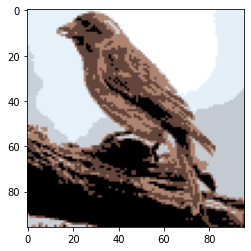

In [26]:
plt.imshow(img_ref.astype(np.uint8))

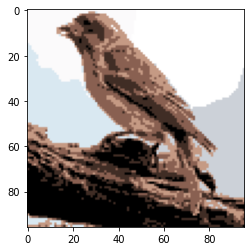

In [27]:
plt.imshow(img_out.astype(np.uint8))